In [1]:
import dataclasses
import re
import textwrap
from enum import Enum, IntEnum
from itertools import groupby
from typing import Sequence, Any, Callable, Literal, Iterable, TypeVar, Optional
import matplotlib.pyplot as plt
import numpy as np

Platform = Literal['ART', 'Hotspot']

T = TypeVar("T")
def grouped_sorted(data: Iterable[T], key: Callable[[T], Any]):
    return groupby(sorted(data, key=key), key=key)

def tick_or_cross(value: bool) -> str:
    return "✓" if value else "✗"

def make_title_string(value: str) -> str:
    return value[0].upper() + value[1:] if value else value

def make_regular_string(value: str) -> str:
    return value[0].lower() + value[1:] if value else value

non_grouping_attributes = {"result", "stddev", "size", "type"}

pic_prefix = "pics/"
pic_format = "svg"

def make_file_name(x) -> str:
    attributes_ = [str(v).lower() for k, v in x.__dict__.items() if k not in non_grouping_attributes]
    return pic_prefix + "_".join([x.__class__.__name__] + attributes_) + f".{pic_format}"

def make_markdown_image_ref(file_name: str) -> str:
    return f"![image]({file_name})"

def formatted_result(item):
    if item.result < 1_000:
        unit = "ns"
        result = item.result
        stddev = item.stddev
    elif item.result < 1_000_000:
        unit = "mcs"
        result = item.result / 1_000
        stddev = item.stddev / 1_000
    else:
        unit = "ms"
        result = item.result / 1_000_000
        stddev = item.stddev / 1_000_000
    return result, stddev, unit

def avg(t: Sequence) -> float:
    return sum(t) / len(t)

In [2]:
@dataclasses.dataclass
class VArrayData:
    name: str
    platform: Platform
    type: str
    dimension: str
    size: int
    result: float
    stddev: float

def read_varrays_android_data() -> Sequence[VArrayData]:
    lines = open("android-varrays-raw.txt").readlines()
    pattern = re.compile(
        r"^.{32} Benchmark: VArrays(?P<name>.+)Benchmark\.(?P<type>sparse|dense|regular)(?P<dimension>2D|3D)_(?P<size>\d+)\[Metric \(timeNs\) results: median (?P<result>[^,]+), min[^,]+, max[^,]+, standardDeviation: (?P<stddev>[^,]+),.*")
    lines = [re.match(pattern, line) for line in lines]
    lines = list(filter(None, lines))


    data = [VArrayData(name=line["name"], type=line["type"], dimension=line["dimension"], size=int(line["size"]),
                       result=float(line["result"]), stddev=float(line["stddev"]), platform="ART") for line in lines]
    return data

def read_varrays_hotspot_data() -> Sequence[VArrayData]:
    lines = open("hotspot-results-raw.txt").readlines()
    pattern = re.compile(
        r"^VArrays\.(?P<name>.*)(?P<type>Sparse|Dense|Regular)(?P<dimension>2D|3D) +N/A +(?P<size>\d+) +N/A +sample +\d+ +(?P<result>[^ ]+) ± +(?P<stddev>[^ ]+) +ns/op$")
    lines = [re.match(pattern, line) for line in lines]
    lines = list(filter(None, lines))


    data = [VArrayData(name=line["name"], type=line["type"], dimension=line["dimension"], size=int(line["size"]),
                       result=float(line["result"]), stddev=float(line["stddev"]), platform="Hotspot") for line in lines]
    return data

def read_varrays_data() -> Sequence[VArrayData]:
    return [*read_varrays_hotspot_data(), *read_varrays_android_data()]

read_varrays_data()

[VArrayData(name='generate', platform='Hotspot', type='Dense', dimension='2D', size=10, result=73.243, stddev=2.357),
 VArrayData(name='generate', platform='Hotspot', type='Dense', dimension='2D', size=1000, result=1307.201, stddev=36.75),
 VArrayData(name='generate', platform='Hotspot', type='Dense', dimension='2D', size=100000, result=92142.484, stddev=507.303),
 VArrayData(name='generate', platform='Hotspot', type='Dense', dimension='3D', size=10, result=99.652, stddev=3.65),
 VArrayData(name='generate', platform='Hotspot', type='Dense', dimension='3D', size=1000, result=2215.288, stddev=35.599),
 VArrayData(name='generate', platform='Hotspot', type='Dense', dimension='3D', size=100000, result=182314.561, stddev=987.387),
 VArrayData(name='generate', platform='Hotspot', type='Regular', dimension='2D', size=10, result=92.647, stddev=7.489),
 VArrayData(name='generate', platform='Hotspot', type='Regular', dimension='2D', size=1000, result=3020.863, stddev=73.13),
 VArrayData(name='gen

In [3]:
def make_varrays_table(data: Sequence[VArrayData]):
    lines = ["# VArrays", textwrap.dedent("""
         These tests compare different implementations of VArrays with MFVC (2D double points and 3D double points) inside:
         * Regular: regular arrays `Array<Point>` which box their argument.
         * Dense: point is stored in a single double array where coordinates are stored sequentially. Such storage is cache-friendly and boxing-free.
         * Sparse: each coordinate is stored in its own array. This may be caused by different MFVC field types: they cannot be stored in the same array. This is less cache-friendly but still without boxing.
         """
    )]
    for platform, items0 in grouped_sorted(data, key=lambda x: x.platform):
        lines.append(f"## {platform}")
        for name, items1 in grouped_sorted(items0, key=lambda x: x.name):
            items1 = list(items1)
            lines.append(f"### {make_title_string(name)}")
            lines.append("| Dimension | Size | Type | Time |")
            lines.append("| :---: | ---: | :---: | :--- |")
            for dimension, items2 in grouped_sorted(items1, key=lambda x: x.dimension):
                items2 = list(items2)
                baseline_type = "regular"
                for _, items3 in groupby(sorted(items2, key=lambda x: (x.size, x.type.lower() != baseline_type, x.type)), key=lambda x: x.size):
                    items_ = list(items3)
                    baseline = [item.result for item in items_ if item.type.lower() == baseline_type][0]
                    for item in items_:
                        percentage = None if item.type.lower() == baseline_type else item.result * 100 / baseline
                        result, stddev, unit = formatted_result(item)
                        lines.append(
                            "| {} | {} | {} | {:.2f} ± {:.2f} {}{} |".format(dimension, item.size, make_title_string(item.type), result, stddev, unit, f" ({percentage:.0f}% of {make_regular_string(baseline_type)})" if percentage else ""))
            lines.append("")
            examples = [list(items)[0] for _, items in groupby(items1, key=lambda x: x.dimension)]
            lines.append(textwrap.dedent(f"""
            <table style="border: none; border-collapse: collapse;">
            <tr style="border: none;"> <td style="border: none; padding: 0;"><img src="{make_file_name(examples[0])}"/></td><td style="border: none; padding: 0;"><img src="{make_file_name(examples[1])}"/></td>
            </table>

            """))
    return "\n".join(lines)


print(make_varrays_table(read_varrays_data()))


# VArrays

These tests compare different implementations of VArrays with MFVC (2D double points and 3D double points) inside:
* Regular: regular arrays `Array<Point>` which box their argument.
* Dense: point is stored in a single double array where coordinates are stored sequentially. Such storage is cache-friendly and boxing-free.
* Sparse: each coordinate is stored in its own array. This may be caused by different MFVC field types: they cannot be stored in the same array. This is less cache-friendly but still without boxing.

## ART
### Generation
| Dimension | Size | Type | Time |
| :---: | ---: | :---: | :--- |
| 2D | 10 | Regular | 1.24 ± 0.07 mcs |
| 2D | 10 | Dense | 365.88 ± 19.98 ns (29% of regular) |
| 2D | 10 | Sparse | 422.81 ± 39.56 ns (34% of regular) |
| 2D | 1000 | Regular | 97.42 ± 1.26 mcs |
| 2D | 1000 | Dense | 32.75 ± 1.39 mcs (34% of regular) |
| 2D | 1000 | Sparse | 17.15 ± 0.50 mcs (18% of regular) |
| 2D | 100000 | Regular | 10.50 ± 0.38 ms |
| 2D | 100000 | De

In [4]:
from matplotlib.axes import Axes


def make_histogram(
        title: Callable[[T], str],
        maps: Sequence[T],
        save: bool=False,
        show: bool=True,
):
    if not maps:
        return
    get_size: Optional[Callable[[T], int]] = (lambda x: x.size) if hasattr(maps[0], 'size') else None
    grouping_attrs = [key for key in maps[0].__dict__.keys() if key not in non_grouping_attributes]
    for group_key, items in grouped_sorted(maps, lambda x: [getattr(x, attr) for attr in grouping_attrs]):
        items = list(items)

        items_by_types = {k: list(v) for k, v in grouped_sorted(items, lambda x: x.type)}
        types = sorted(list(items_by_types.keys()))
        width = min(0.9 / len(types), 0.35)  # the width of the bars

        fig, ax = plt.subplots()
        ax: Axes
        fig.set_size_inches(8, 6)
        if get_size:
            sizes = sorted(list({get_size(item) for item in items}))  # labels
            maps = {type_: {it.size: it.result for it in items_with_type} for type_, items_with_type in items_by_types.items()}
            result = { type_: [maps[type_].get(size, None) for size in sizes] for type_ in types}
        else:
            sizes = [1]
            result = { type_: [items_with_type[0].result] for type_, items_with_type in items_by_types.items()}
            ax.tick_params(bottom = False, labelbottom = False)
        if len(sizes) == 1:
            ax.set_xlim(-sizes[0], sizes[0])
            width = sizes[0] / 5
        else:
            ax.tick_params(left = False, labelleft = False)

        x = np.arange(len(sizes))
        average_size = [avg(list(filter(None, (result[type_][i] for type_ in types)))) for i in range(len(sizes))] if len(sizes) != 1 else [1.0]
        for type_, i in zip(types, range(len(types))):
            scaled_result = [res / avg_res if res is not None else None for res, avg_res in zip(result[type_], average_size)]
            rect = ax.bar(x - width * len(types) / 2 + width * i + width / 2, scaled_result, width, label=type_)
            ax.bar_label(rect, [ (f"{res:.2e}" if res >= 1000 else f"{res:.2f}") if res else "" for res in result[type_]], padding=3)
        ax.set_ylabel("ns")
        if get_size:
            ax.set_xticks(x, sizes)
        ax.set_title(title(items[0]))
        ax.legend()
        fig.tight_layout()
        if save:
            plt.savefig(make_file_name(items[0]))
        if show:
            plt.show()

In [5]:
@dataclasses.dataclass
class ShadowStackData:
    type: str
    platform: Platform
    size: int
    result: float
    stddev: float

def read_shadow_stack_android_data() -> Sequence[ShadowStackData]:
    lines = open("android-value-classes-raw.txt").readlines()
    pattern = re.compile(
        r"^.{32} Benchmark: ShadowStackBenchmark\.(?P<type>.+)_(?P<size>\d+)\[Metric \(timeNs\) results: median (?P<result>[^,]+), min[^,]+, max[^,]+, standardDeviation: (?P<stddev>[^,]+),.*")
    lines = [re.match(pattern, line) for line in lines]
    lines = list(filter(None, lines))

    data = [ShadowStackData(type=line["type"], platform="ART", size=int(line["size"]), result=float(line["result"]), stddev=float(line["stddev"])) for line in lines]
    return data

def read_shadow_stack_hotspot_data() -> Sequence[ShadowStackData]:
    lines = open("hotspot-results-raw.txt").readlines()
    pattern = re.compile(
        r"^MfvcShadowStack\.(?P<type>[^ ]+) +(?P<size>\d+) +N/A +N/A +sample +\d+ +(?P<result>[^ ]+) ± +(?P<stddev>[^ ]+) +ns/op$")
    lines = [re.match(pattern, line) for line in lines]
    lines = list(filter(None, lines))


    data = [ShadowStackData(type=line["type"], size=int(line["size"]), result=float(line["result"]), stddev=float(line["stddev"]), platform="Hotspot") for line in lines]
    return data

def read_shadow_stack_data() -> Sequence[ShadowStackData]:
    return [*read_shadow_stack_hotspot_data(), *read_shadow_stack_android_data()]

In [6]:
def make_shadow_stack_table(data: Sequence[ShadowStackData]):
    lines = ["# Shadow stack", textwrap.dedent("""
        Shadow stack is one of the workarounds to overcome inability to return multiple values unboxed in JVM.
        * It can be applied to any function, not only inline. Even to recursive functions.
        * It is either non-threadsafe but fast or inefficient but thread-safe.

        Exclusive guaranty cannot be verified by compiler because the shadow stack is just a regular object, while locks may be very expensive.
        However, this guaranty can be provided by user so such approach may be useful.

        This benchmark compares shadow stack-based function returns to box-based ones.
        """
    )]
    baseline_type = "boxed"
    for platform, items0 in grouped_sorted(data, key=lambda x: x.platform):
        items0 = list(items0)
        lines.append(f"## {platform}")
        lines.append("| Size | Type | Time |")
        lines.append("| ---: | :---: | :--- |")
        for _, items in groupby(sorted(items0, key=lambda x: (x.size, x.type.lower() != baseline_type, x.type)), key=lambda x: x.size):
            items_ = list(items)
            baseline = [item.result for item in items_ if item.type.lower() == baseline_type][0]
            for item in items_:
                percentage = None if item.type.lower() == baseline_type else item.result * 100 / baseline
                result, stddev, unit = formatted_result(item)
                lines.append(
                    "| {} | {} | {:.2f} ± {:.2f} {}{} |".format(item.size, make_title_string(item.type), result, stddev, unit, f" ({percentage:.0f}% of {make_regular_string(baseline_type)})" if percentage else ""))
        lines.append("")
        lines.append(make_markdown_image_ref(make_file_name(items0[0])))
        lines.append("")
    return "\n".join(lines)


print(make_shadow_stack_table(read_shadow_stack_data()))

# Shadow stack

Shadow stack is one of the workarounds to overcome inability to return multiple values unboxed in JVM.
* It can be applied to any function, not only inline. Even to recursive functions.
* It is either non-threadsafe but fast or inefficient but thread-safe.

Exclusive guaranty cannot be verified by compiler because the shadow stack is just a regular object, while locks may be very expensive.
However, this guaranty can be provided by user so such approach may be useful.

This benchmark compares shadow stack-based function returns to box-based ones.

## ART
| Size | Type | Time |
| ---: | :---: | :--- |
| 1 | Boxed | 113.04 ± 26.47 ns |
| 1 | BoxedWithExistingStorage | 10.32 ± 15.35 ns (9% of boxed) |
| 1 | BoxedWithNewStorage | 43.87 ± 32.98 ns (39% of boxed) |
| 1 | ExistingShadow | 38.45 ± 17.02 ns (34% of boxed) |
| 1 | ExistingShadowWithCache | 10.30 ± 18.88 ns (9% of boxed) |
| 1 | NewShadow | 140.36 ± 23.55 ns (124% of boxed) |
| 1 | NewShadowWithCache | 76.35 ± 53.

In [7]:
@dataclasses.dataclass
class LongPackData:
    type: str
    platform: Platform
    result: float
    stddev: float

def read_long_pack_android_data() -> Sequence[LongPackData]:
    lines = open("android-value-classes-raw.txt").readlines()
    pattern = re.compile(
        r"^.{32} Benchmark: LongPackBenchmark\.(?P<type>.+)\[Metric \(timeNs\) results: median (?P<result>[^,]+), min[^,]+, max[^,]+, standardDeviation: (?P<stddev>[^,]+),.*")
    lines = [re.match(pattern, line) for line in lines]
    lines = list(filter(None, lines))

    data = [LongPackData(type=line["type"], platform="ART", result=float(line["result"]), stddev=float(line["stddev"])) for line in lines]
    return data

def read_long_pack_hotspot_data() -> Sequence[LongPackData]:
    lines = open("hotspot-results-raw.txt").readlines()
    pattern = re.compile(
        r"^ValueClassesLongPack\.(?P<type>[^ ]+?)_?( +N/A)* +sample +\d+ +(?P<result>[^ ]+) ± +(?P<stddev>[^ ]+) +ns/op$")
    lines = [re.match(pattern, line) for line in lines]
    lines = list(filter(None, lines))


    data = [LongPackData(type=line["type"], result=float(line["result"]), stddev=float(line["stddev"]), platform="Hotspot") for line in lines]
    return data

def read_long_pack_data() -> Sequence[LongPackData]:
    return [*read_long_pack_hotspot_data(), *read_long_pack_android_data()]

In [8]:
def make_long_pack_table(data: Sequence[LongPackData]):
    lines = ["# `Long` pack", textwrap.dedent("""
        Another workaround is packing in `Long`. If a value class contains only primitives with not more than 64 bits, it is possible to pack them inside `Long` and return. Besides mentioned limitation, there is no other applicability issues for the strategy.

        This benchmark compares `Long`-based, "existing mutable wrapper"-based function returns to box-based ones.
        """
                                               )]
    baseline_type = "box"
    for platform, items1 in grouped_sorted(data, key=lambda x: x.platform):
        lines.append(f"## {platform}")
        lines.append("| Type | Time |")
        lines.append("| :---: | :--- |")
        items2 = sorted(items1, key=lambda x: (x.type.lower() != baseline_type, x.type))
        baseline = [item.result for item in items2 if item.type.lower() == baseline_type][0]
        for item in items2:
            percentage = None if item.type.lower() == baseline_type else item.result * 100 / baseline
            result, stddev, unit = formatted_result(item)
            lines.append(
                "| {} | {:.2f} ± {:.2f} {}{} |".format(make_title_string(item.type), result, stddev, unit, f" ({percentage:.0f}% of {make_regular_string(baseline_type)})" if percentage else ""))
        lines.append("")
        lines.append(make_markdown_image_ref(make_file_name(items2[0])))
        lines.append("")
    return "\n".join(lines)


print(make_long_pack_table(read_long_pack_data()))

# `Long` pack

Another workaround is packing in `Long`. If a value class contains only primitives with not more than 64 bits, it is possible to pack them inside `Long` and return. Besides mentioned limitation, there is no other applicability issues for the strategy.

This benchmark compares `Long`-based, "existing mutable wrapper"-based function returns to box-based ones.

## ART
| Type | Time |
| :---: | :--- |
| Box | 81.33 ± 79.31 ns |
| ExistingWrapper | 13.99 ± 64.43 ns (17% of box) |
| Long | 12.42 ± 78.06 ns (15% of box) |

![image](pics/LongPackData_art.svg)

## Hotspot
| Type | Time |
| :---: | :--- |
| Box | 60.95 ± 0.57 ns |
| ExistingWrapper | 59.02 ± 0.33 ns (97% of box) |
| Long | 57.03 ± 0.31 ns (94% of box) |

![image](pics/LongPackData_hotspot.svg)



In [9]:
class BoxUsageBehavior(Enum):
    NotUsingLocally = 1
    UsingLocally = 2
    NotUsingPassed = 3
    UsingPassed = 4

    def __lt__(self, other: 'BoxUsageBehavior'):
        return self.value < other.value

    def __str__(self):
        return self.name

    @property
    def is_box_passed(self):
        return self == BoxUsageBehavior.NotUsingPassed or self == BoxUsageBehavior.UsingPassed

    @property
    def is_box_used(self):
        return self == BoxUsageBehavior.UsingLocally or self == BoxUsageBehavior.UsingPassed

@dataclasses.dataclass
class BoxUsageData:
    type: str
    platform: Platform
    behavior: BoxUsageBehavior
    result: float
    stddev: float

behaviors = '|'.join(map(lambda x: x.name, BoxUsageBehavior))

def read_box_usage_android_data() -> Sequence[BoxUsageData]:
    lines = open("android-value-classes-raw.txt").readlines()
    pattern = re.compile(
        fr"^.{{32}} Benchmark: ValueClassesBoxUsage\.(?P<type>.+?)(?P<behavior>{behaviors})\[Metric \(timeNs\) results: median (?P<result>[^,]+), min[^,]+, max[^,]+, standardDeviation: (?P<stddev>[^,]+),.*")
    lines = [re.match(pattern, line) for line in lines]
    lines = list(filter(None, lines))

    data = [BoxUsageData(
        type=line["type"],
        result=float(line["result"]),
        stddev=float(line["stddev"]),
        platform="ART",
        behavior=BoxUsageBehavior[line["behavior"]],
    ) for line in lines]
    return data

def read_box_usage_hotspot_data() -> Sequence[BoxUsageData]:
    lines = open("hotspot-results-raw.txt").readlines()
    pattern = re.compile(
        fr"^ValueClassesBoxUsageDouble\.(?P<type>[^ ]+?)(?P<behavior>{behaviors}) +sample +\d+ +(?P<result>[^ ]+) ± +(?P<stddev>[^ ]+) +ns/op$")
    lines = [re.match(pattern, line) for line in lines]
    lines = list(filter(None, lines))


    data = [BoxUsageData(
        type=line["type"],
        result=float(line["result"]),
        stddev=float(line["stddev"]),
        platform="Hotspot",
        behavior=BoxUsageBehavior[line["behavior"]]
    ) for line in lines]
    return data

def read_box_usage_data() -> Sequence[BoxUsageData]:
    return [*read_box_usage_hotspot_data(), *read_box_usage_android_data()]

In [10]:
def make_box_usage_table(data: Sequence[BoxUsageData]):
    lines = ["# Box usage", textwrap.dedent("""
        Regular classes have to be boxed, but they do it once and never rebox. MFVC are not boxed by default but there are limitations that make them box. However, each time, the same MFVC needs to become boxed, it creates a new box. So, it is better to preserve box when it is possible. To do this, we may store and reuse boxed instances (if they were received) for each MFVC and its MFVC subnodes and pass them as parameters. However, it prolongs lives of probably temporary boxes and takes extra time to pass the wrappers as arguments.

         These benchmarks show the problem and the solution.
        """
    )]
    baseline_type = "regular"
    for platform, items0 in grouped_sorted(data, key=lambda x: x.platform):
        items0 = list(items0)
        lines.append(f"## {platform}")
        lines.append("| Behavior | Type | Time |")
        lines.append("| :---: | :---: | :--- |")
        for behavior, items1 in groupby(sorted(items0, key=lambda x: x.behavior), key=lambda x: x.behavior):
            items = sorted(items1, key=lambda x: (x.behavior, x.type.lower() != baseline_type, x.type))
            baseline = [item.result for item in items if item.type.lower() == baseline_type][0]
            for item in items:
                percentage = None if item.type.lower() == baseline_type else item.result * 100 / baseline
                result, stddev, unit = formatted_result(item)
                lines.append(
                    "| {} | {} | {:.2f} ± {:.2f} {}{} |".format(item.behavior, make_title_string(item.type), result, stddev, unit, f" ({percentage:.0f}% of {make_regular_string(baseline_type)})" if percentage else ""))
        lines.append("")
        examples = {(x.behavior.is_box_passed, x.behavior.is_box_used): x for x in [list(items)[0] for _, items in groupby(items0, key=lambda x: x.behavior)]}
        lines.append(textwrap.dedent(f"""
        <table style="border: none; border-collapse: collapse;">
        <tr style="border: none;"> <td style="border: none; padding: 0;"><img src="{make_file_name(examples[(False, False)])}"/></td><td style="border: none; padding: 0;"><img src="{make_file_name(examples[(False, True)])}"/></td>
        <tr style="border: none;"> <td style="border: none; padding: 0;"><img src="{make_file_name(examples[(True, False)])}"/></td><td style="border: none; padding: 0;"><img src="{make_file_name(examples[(True, True)])}"/></td>
        </table>

        """))
    return "\n".join(lines)


print(make_box_usage_table(read_box_usage_data()))

# Box usage

Regular classes have to be boxed, but they do it once and never rebox. MFVC are not boxed by default but there are limitations that make them box. However, each time, the same MFVC needs to become boxed, it creates a new box. So, it is better to preserve box when it is possible. To do this, we may store and reuse boxed instances (if they were received) for each MFVC and its MFVC subnodes and pass them as parameters. However, it prolongs lives of probably temporary boxes and takes extra time to pass the wrappers as arguments.

 These benchmarks show the problem and the solution.

## ART
| Behavior | Type | Time |
| :---: | :---: | :--- |
| NotUsingLocally | Regular | 293.85 ± 24.40 ns |
| NotUsingLocally | Mfvc | 28.94 ± 0.21 ns (10% of regular) |
| NotUsingLocally | MfvcSmart | 29.91 ± 0.27 ns (10% of regular) |
| UsingLocally | Regular | 197.80 ± 12.99 ns |
| UsingLocally | Mfvc | 519.40 ± 40.16 ns (263% of regular) |
| UsingLocally | MfvcSmart | 296.68 ± 16.38 ns (150% o

In [11]:
@dataclasses.dataclass
class GenerationUsageData:
    type: str
    platform: Platform
    escaping: bool
    nested: bool
    result: float
    stddev: float

def read_generation_usage_android_data() -> Sequence[GenerationUsageData]:
    lines = open("android-value-classes-raw.txt").readlines()
    pattern = re.compile(
        r"^.{32} Benchmark: ValueClassesGeneration\.generate(?P<outer>(Outer)?)DPoints(?P<escaping>(Escaping)?)(?P<type>Regular|MFVC)\[Metric \(timeNs\) results: median (?P<result>[^,]+), min[^,]+, max[^,]+, standardDeviation: (?P<stddev>[^,]+),.*")
    lines = [re.match(pattern, line) for line in lines]
    lines = list(filter(None, lines))

    data = [GenerationUsageData(
        type=line["type"],
        platform="ART",
        escaping=bool(line["escaping"]),
        nested=bool(line["outer"]),
        result=float(line["result"]),
        stddev=float(line["stddev"]),
    ) for line in lines]
    return data

def read_generation_usage_hotspot_data() -> Sequence[GenerationUsageData]:
    lines = open("hotspot-results-raw.txt").readlines()
    pattern = re.compile(
        r"^ValueClassesGenerating\.generate(?P<escaping>(Escaping)?)(?P<outer>(Outer)?)DPoints(?P<type>Mfvc|Regular) +N/A +N/A +N/A +sample +\d+ +(?P<result>[^ ]+) ± +(?P<stddev>[^ ]+) +ns/op$")
    lines = [re.match(pattern, line) for line in lines]
    lines = list(filter(None, lines))


    data = [GenerationUsageData(
        type=line["type"],
        platform="Hotspot",
        escaping=bool(line["escaping"]),
        nested=bool(line["outer"]),
        result=float(line["result"]),
        stddev=float(line["stddev"]),
    ) for line in lines]

    return data

def read_generation_usage_data() -> Sequence[GenerationUsageData]:
    return [*read_generation_usage_hotspot_data(), *read_generation_usage_android_data()]

In [12]:
def make_generation_table(data: Sequence[GenerationUsageData]):
    lines = ["# Generation of MFVC", textwrap.dedent("""
        These benchmarks check generation speed of instances of 2D double points:
        * Nested points store not-nested inside.
        * Escaping tests let the generated point to escape from function scope to check breakage of Scalar replacement optimization.
        """
    )]
    for platform, items1 in grouped_sorted(data, key=lambda x: x.platform):
        lines.append(f"## {platform}")
        lines.append("| Escaping | Nested | Type | Time |")
        lines.append("| :---: | :---: | :---: | :--- |")
        baseline_type = "regular"
        items2 = sorted(items1, key=lambda x: (x.escaping, x.nested, x.type.lower() != baseline_type, x.type))
        items_ = list(items2)
        baseline = [item.result for item in items_ if item.type.lower() == baseline_type][0]
        for item in items_:
            percentage = None if item.type.lower() == baseline_type else item.result * 100 / baseline
            result, stddev, unit = formatted_result(item)
            lines.append(
                "| {} | {} | {} | {:.2f} ± {:.2f} {}{} |".format(tick_or_cross(item.escaping), tick_or_cross(item.nested), make_title_string(item.type), result, stddev, unit, f" ({percentage:.0f}% of {make_regular_string(baseline_type)})" if percentage else ""))
        lines.append("")
        examples = [list(items)[0] for _, items in groupby(items2, key=lambda x: (x.escaping, x.nested))]
        lines.append(textwrap.dedent(f"""
        <table style="border: none; border-collapse: collapse;">
        <tr style="border: none;"> <td style="border: none; padding: 0;"><img src="{make_file_name(examples[0])}"/></td><td style="border: none; padding: 0;"><img src="{make_file_name(examples[1])}"/></td>
        <tr style="border: none;"> <td style="border: none; padding: 0;"><img src="{make_file_name(examples[2])}"/></td><td style="border: none; padding: 0;"><img src="{make_file_name(examples[3])}"/></td>
        </table>

        """))
    return "\n".join(lines)


print(make_generation_table(read_generation_usage_data()))

# Generation of MFVC

These benchmarks check generation speed of instances of 2D double points:
* Nested points store not-nested inside.
* Escaping tests let the generated point to escape from function scope to check breakage of Scalar replacement optimization.

## ART
| Escaping | Nested | Type | Time |
| :---: | :---: | :---: | :--- |
| ✗ | ✗ | Regular | 46.47 ± 39.80 ns |
| ✗ | ✗ | MFVC | 10.32 ± 21.94 ns (22% of regular) |
| ✗ | ✓ | Regular | 84.30 ± 42.96 ns |
| ✗ | ✓ | MFVC | 10.32 ± 36.26 ns (22% of regular) |
| ✓ | ✗ | Regular | 48.27 ± 37.55 ns |
| ✓ | ✗ | MFVC | 9.60 ± 44.69 ns (21% of regular) |
| ✓ | ✓ | Regular | 85.10 ± 43.07 ns |
| ✓ | ✓ | MFVC | 9.52 ± 61.05 ns (20% of regular) |


<table style="border: none; border-collapse: collapse;">
<tr style="border: none;"> <td style="border: none; padding: 0;"><img src="pics/GenerationUsageData_art_false_false.svg"/></td><td style="border: none; padding: 0;"><img src="pics/GenerationUsageData_art_false_true.svg"/></td>
<tr style

In [13]:
@dataclasses.dataclass
class ComplexUsageData:
    type: str
    platform: Platform
    size: int
    nested: bool
    result: float
    stddev: float

def read_complex_usage_android_data() -> Sequence[ComplexUsageData]:
    lines = open("android-value-classes-raw.txt").readlines()
    pattern = re.compile(
        r"^.{32} Benchmark: ValueClassesSearch\.searchDPoints(?P<type>Regular|MFVC)(?P<outer>(Outer)?)(?P<size>\d+)\[Metric \(timeNs\) results: median (?P<result>[^,]+), min[^,]+, max[^,]+, standardDeviation: (?P<stddev>[^,]+),.*")
    lines = [re.match(pattern, line) for line in lines]
    lines = list(filter(None, lines))

    data = [ComplexUsageData(
        type=line["type"],
        platform="ART",
        size=int(line["size"]),
        nested=bool(line["outer"]),
        result=float(line["result"]),
        stddev=float(line["stddev"]),
    ) for line in lines]
    return data

def read_complex_usage_hotspot_data() -> Sequence[ComplexUsageData]:
    lines = open("hotspot-results-raw.txt").readlines()
    pattern = re.compile(
        r"^ValueClassesComplexUsageDouble\.search(?P<type>Regular|Mfvc)(?P<outer>(Outer)?) +N/A +(?P<size>\d+) +N/A +sample +\d+ +(?P<result>[^ ]+) ± +(?P<stddev>[^ ]+) +ns/op$")
    lines = [re.match(pattern, line) for line in lines]
    lines = list(filter(None, lines))

    data = [ComplexUsageData(
        type=line["type"],
        platform="Hotspot",
        size=int(line["size"]),
        nested=bool(line["outer"]),
        result=float(line["result"]),
        stddev=float(line["stddev"]),
    ) for line in lines]
    return data

def read_complex_usage_data() -> Sequence[ComplexUsageData]:
    return [*read_complex_usage_hotspot_data(), *read_complex_usage_android_data()]

In [14]:
def make_complex_usage_table(data: Sequence[ComplexUsageData]):
    lines = ["# Complex usage of MFVC", textwrap.dedent("""
        These tests perform calculating of Collatz sequence for 2D points as it can not be optimized by the compiler and runtime because there is no known proof that its ends with 1.

        Nested points store not-nested inside.
        """
    )]
    for platform, items1 in grouped_sorted(data, key=lambda x: x.platform):
        items1 = list(items1)
        lines.append(f"## {platform}")
        lines.append("| Nested | Size | Type | Time |")
        lines.append("| :---: | ---: | :---: | :--- |")
        baseline_type = "regular"
        for _, items2 in groupby(sorted(items1, key=lambda x: (x.nested, x.size, x.type.lower() != baseline_type, x.type)), key=lambda x: x.size):
            items_ = list(items2)
            baseline = [item.result for item in items_ if item.type.lower() == baseline_type][0]
            for item in items_:
                percentage = None if item.type.lower() == baseline_type else item.result * 100 / baseline
                result, stddev, unit = formatted_result(item)
                lines.append(
                    "| {} | {} | {} | {:.2f} ± {:.2f} {}{} |".format(tick_or_cross(item.nested), item.size, make_title_string(item.type), result, stddev, unit, f" ({percentage:.0f}% of {make_regular_string(baseline_type)})" if percentage else ""))
        lines.append("")
        examples = [list(items)[0] for _, items in groupby(items1, key=lambda x: x.nested)]
        lines.append(textwrap.dedent(f"""
        <table style="border: none; border-collapse: collapse;">
        <tr style="border: none;"> <td style="border: none; padding: 0;"><img src="{make_file_name(examples[0])}"/></td><td style="border: none; padding: 0;"><img src="{make_file_name(examples[1])}"/></td>
        </table>

        """))
    return "\n".join(lines)


print(make_complex_usage_table(read_complex_usage_data()))

# Complex usage of MFVC

These tests perform calculating of Collatz sequence for 2D points as it can not be optimized by the compiler and runtime because there is no known proof that its ends with 1.

Nested points store not-nested inside.

## ART
| Nested | Size | Type | Time |
| :---: | ---: | :---: | :--- |
| ✗ | 10 | Regular | 692.48 ± 58.96 ns |
| ✗ | 10 | MFVC | 414.35 ± 2.98 ns (60% of regular) |
| ✗ | 100 | Regular | 3.26 ± 0.07 mcs |
| ✗ | 100 | MFVC | 1.79 ± 0.01 mcs (55% of regular) |
| ✗ | 1000 | Regular | 30.28 ± 0.63 mcs |
| ✗ | 1000 | MFVC | 13.82 ± 0.25 mcs (46% of regular) |
| ✓ | 10 | Regular | 1.66 ± 0.09 mcs |
| ✓ | 10 | MFVC | 335.48 ± 3.16 ns (20% of regular) |
| ✓ | 100 | Regular | 4.43 ± 0.11 mcs |
| ✓ | 100 | MFVC | 1.79 ± 0.01 mcs (40% of regular) |
| ✓ | 1000 | Regular | 25.07 ± 0.74 mcs |
| ✓ | 1000 | MFVC | 16.42 ± 0.39 mcs (66% of regular) |


<table style="border: none; border-collapse: collapse;">
<tr style="border: none;"> <td style="border: none; paddi

In [15]:
@dataclasses.dataclass
class InlineFunctionsUsageData:
    type: str
    platform: Platform
    result: float
    stddev: float

def read_inline_functions_usage_android_data() -> Sequence[InlineFunctionsUsageData]:
    lines = open("android-value-classes-raw.txt").readlines()
    pattern = re.compile(
        r"^.{32} Benchmark: ValueClassesInlineFunctionsUsage\.(?P<type>regular|mfvc)\[Metric \(timeNs\) results: median (?P<result>[^,]+), min[^,]+, max[^,]+, standardDeviation: (?P<stddev>[^,]+),.*")
    lines = [re.match(pattern, line) for line in lines]
    lines = list(filter(None, lines))

    data = [InlineFunctionsUsageData(
        type=line["type"],
        platform="ART",
        result=float(line["result"]),
        stddev=float(line["stddev"]),
    ) for line in lines]
    return data

def read_inline_functions_usage_hotspot_data() -> Sequence[InlineFunctionsUsageData]:
    lines = open("hotspot-results-raw.txt").readlines()
    pattern = re.compile(
        r"^ValueClassesInlineFunctionsUsageDouble\.(?P<type>regular|mfvc) +N/A +N/A +N/A +sample +\d+ +(?P<result>[^ ]+) ± +(?P<stddev>[^ ]+) +ns/op$")
    lines = [re.match(pattern, line) for line in lines]
    lines = list(filter(None, lines))

    data = [InlineFunctionsUsageData(
        type=line["type"],
        platform="Hotspot",
        result=float(line["result"]),
        stddev=float(line["stddev"]),
    ) for line in lines]
    return data

def read_inline_functions_usage_data() -> Sequence[InlineFunctionsUsageData]:
    return [*read_inline_functions_usage_hotspot_data(), *read_inline_functions_usage_android_data()]

In [16]:
def make_inline_functions_usage_table(data: Sequence[InlineFunctionsUsageData]):
    lines = ["# Usage of inline functions returning MFVC", textwrap.dedent("""
        Returning from inline function can be done without boxing because inline function reuses callee's stackframe and its local variables. It can successfully pass the result with them.
        """
    )]
    for platform, items1 in grouped_sorted(data, key=lambda x: x.platform):
        lines.append(f"## {platform}")
        lines.append("| Type | Time |")
        lines.append("| :---: | :--- |")
        baseline_type = "regular"
        items2 = sorted(items1, key=lambda x: (x.type.lower() != baseline_type, x.type))
        baseline = [item.result for item in items2 if item.type.lower() == baseline_type][0]
        for item in items2:
            percentage = None if item.type.lower() == baseline_type else item.result * 100 / baseline
            result, stddev, unit = formatted_result(item)
            lines.append(
                "| {} | {:.2f} ± {:.2f} {}{} |".format(make_title_string(item.type), result, stddev, unit, f" ({percentage:.0f}% of {make_regular_string(baseline_type)})" if percentage else ""))
        lines.append("")
        lines.append(make_markdown_image_ref(make_file_name(items2[0])))
        lines.append("")
    return "\n".join(lines)


print(make_inline_functions_usage_table(read_inline_functions_usage_data()))

# Usage of inline functions returning MFVC

Returning from inline function can be done without boxing because inline function reuses callee's stackframe and its local variables. It can successfully pass the result with them.

## ART
| Type | Time |
| :---: | :--- |
| Regular | 487.65 ± 274.42 ns |
| Mfvc | 8.50 ± 3.01 ns (2% of regular) |

![image](pics/InlineFunctionsUsageData_art.svg)

## Hotspot
| Type | Time |
| :---: | :--- |
| Regular | 59.78 ± 1.77 ns |
| Mfvc | 65.03 ± 5.75 ns (109% of regular) |

![image](pics/InlineFunctionsUsageData_hotspot.svg)



In [17]:
with open("Readme.md", "w") as f:
    f.writelines("\n\n".join([
        make_shadow_stack_table(read_shadow_stack_data()),
        make_long_pack_table(read_long_pack_data()),
        make_generation_table(read_generation_usage_data()),
        make_complex_usage_table(read_complex_usage_data()),
        make_inline_functions_usage_table(read_inline_functions_usage_data()),
        make_box_usage_table(read_box_usage_data()),
        make_varrays_table(read_varrays_data()),
    ]))
with open("Readme.md", "r") as f:
    print(f.read())

# Shadow stack

Shadow stack is one of the workarounds to overcome inability to return multiple values unboxed in JVM.
* It can be applied to any function, not only inline. Even to recursive functions.
* It is either non-threadsafe but fast or inefficient but thread-safe.

Exclusive guaranty cannot be verified by compiler because the shadow stack is just a regular object, while locks may be very expensive.
However, this guaranty can be provided by user so such approach may be useful.

This benchmark compares shadow stack-based function returns to box-based ones.

## ART
| Size | Type | Time |
| ---: | :---: | :--- |
| 1 | Boxed | 113.04 ± 26.47 ns |
| 1 | BoxedWithExistingStorage | 10.32 ± 15.35 ns (9% of boxed) |
| 1 | BoxedWithNewStorage | 43.87 ± 32.98 ns (39% of boxed) |
| 1 | ExistingShadow | 38.45 ± 17.02 ns (34% of boxed) |
| 1 | ExistingShadowWithCache | 10.30 ± 18.88 ns (9% of boxed) |
| 1 | NewShadow | 140.36 ± 23.55 ns (124% of boxed) |
| 1 | NewShadowWithCache | 76.35 ± 53.

/var/folders/vt/zj35w07x6fj7lyq4ypb1n5pm0000kt/T/ipykernel_11568/3082413764.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


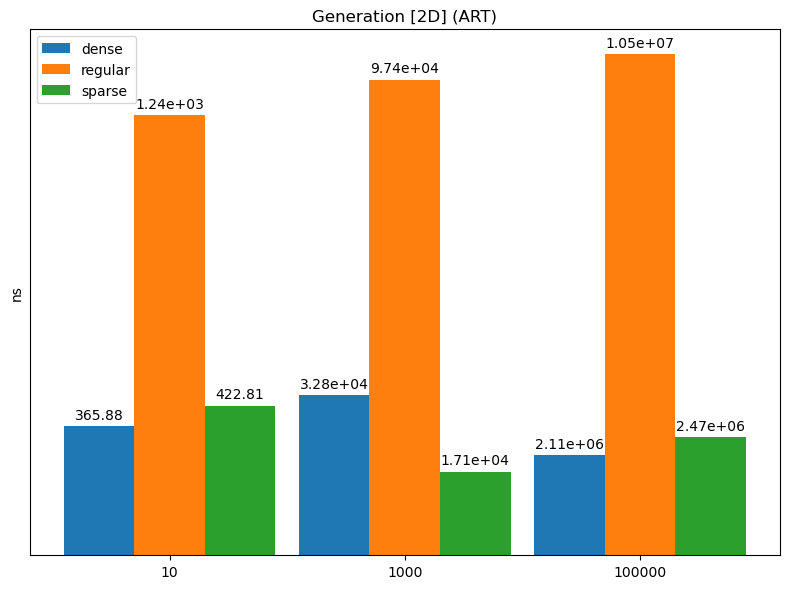

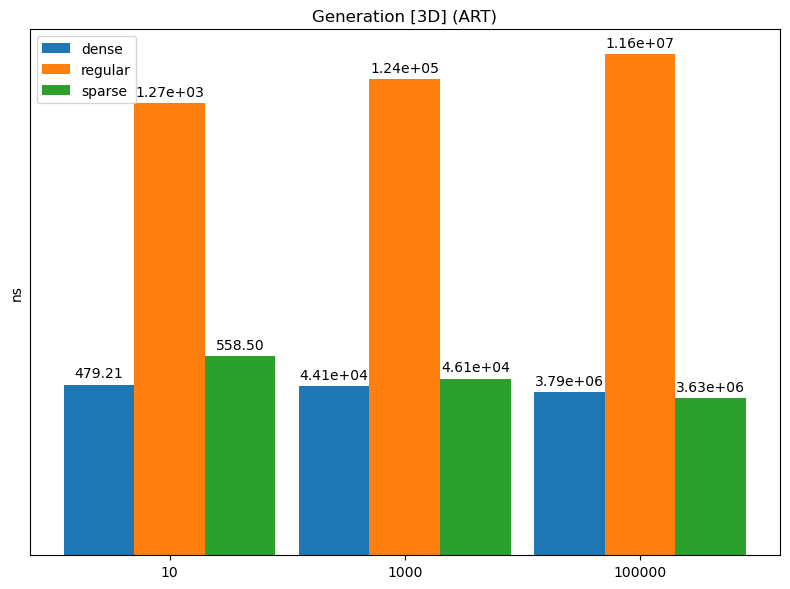

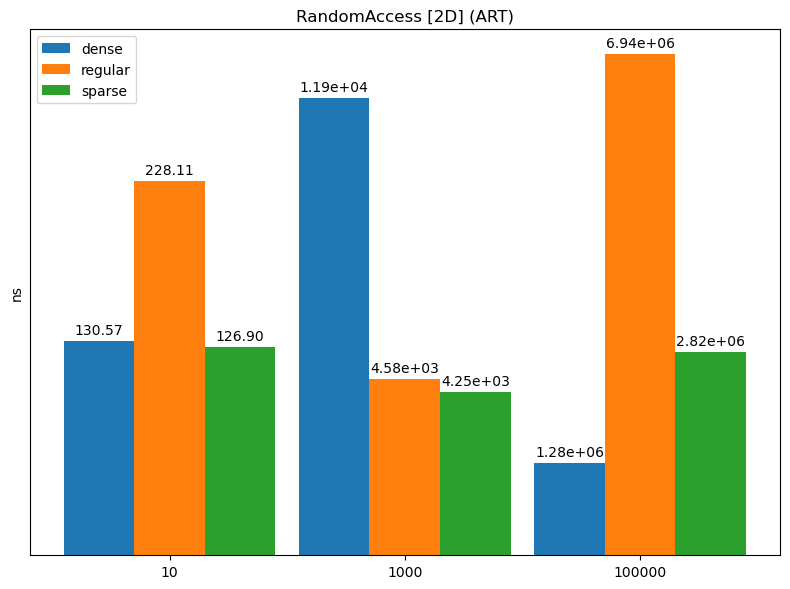

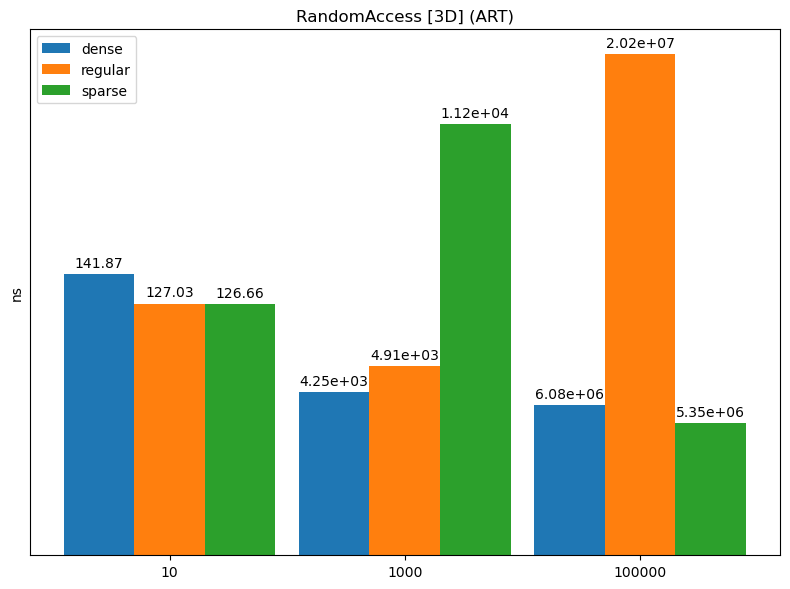

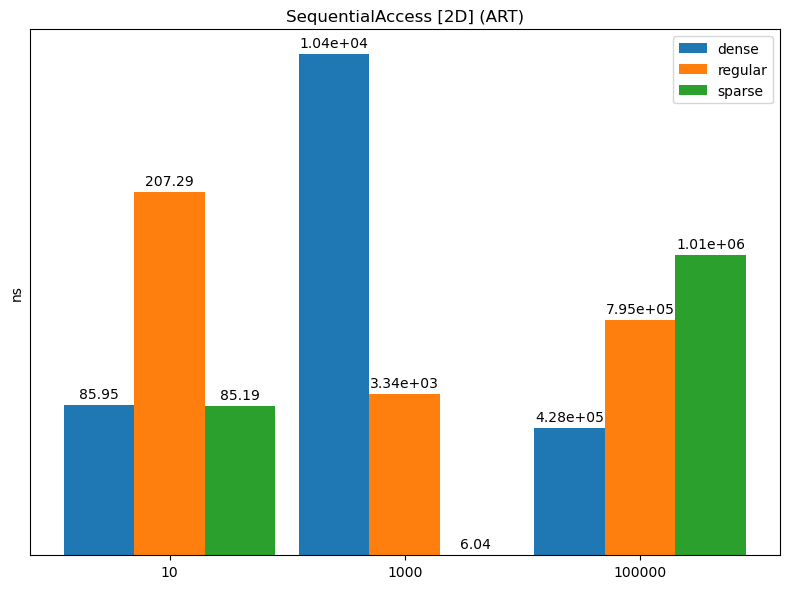

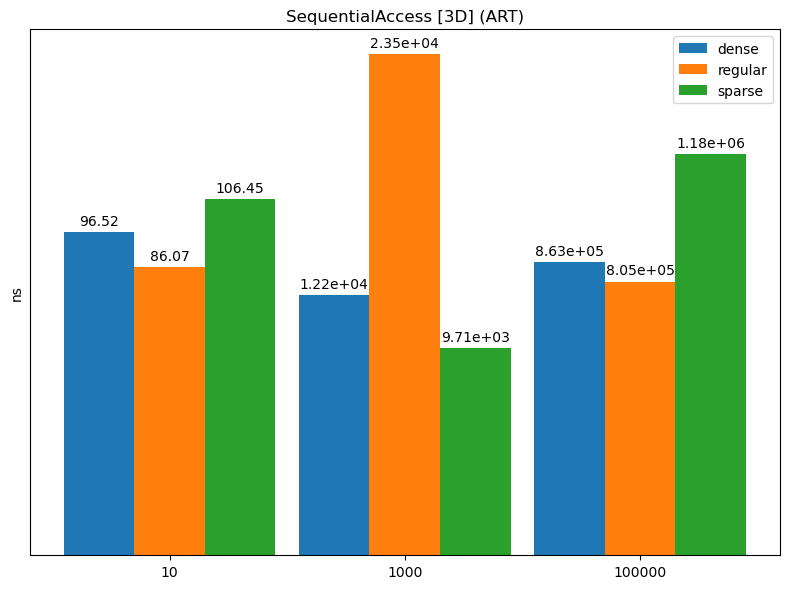

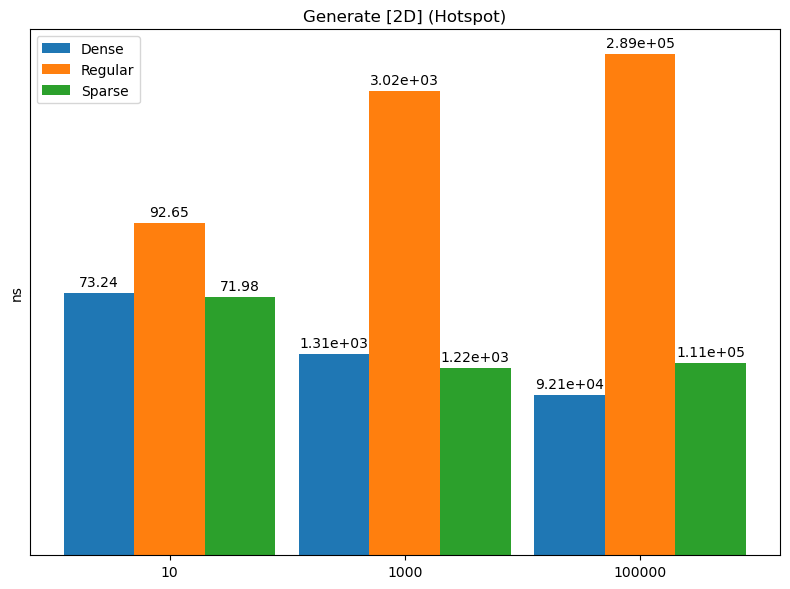

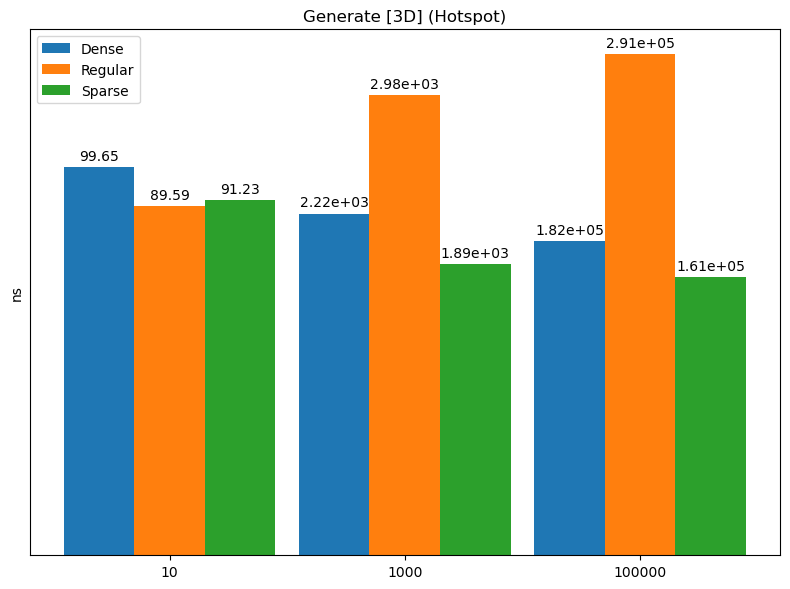

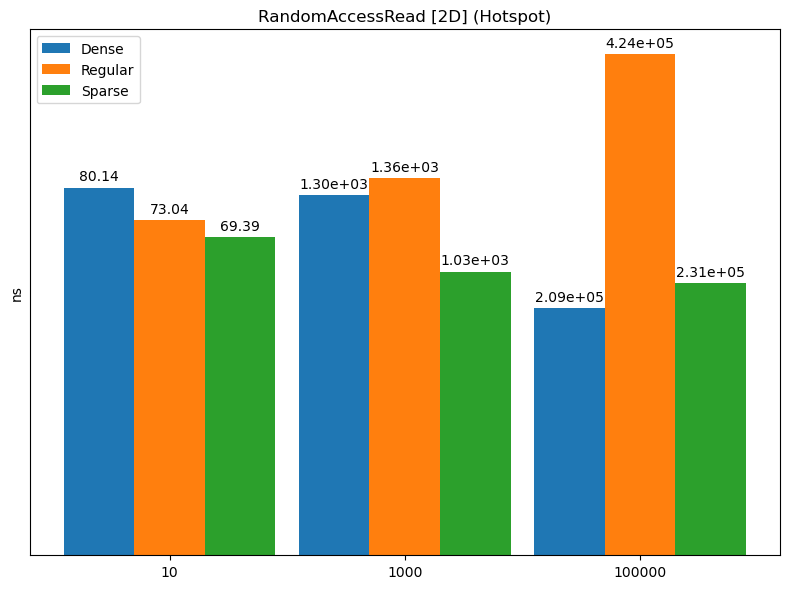

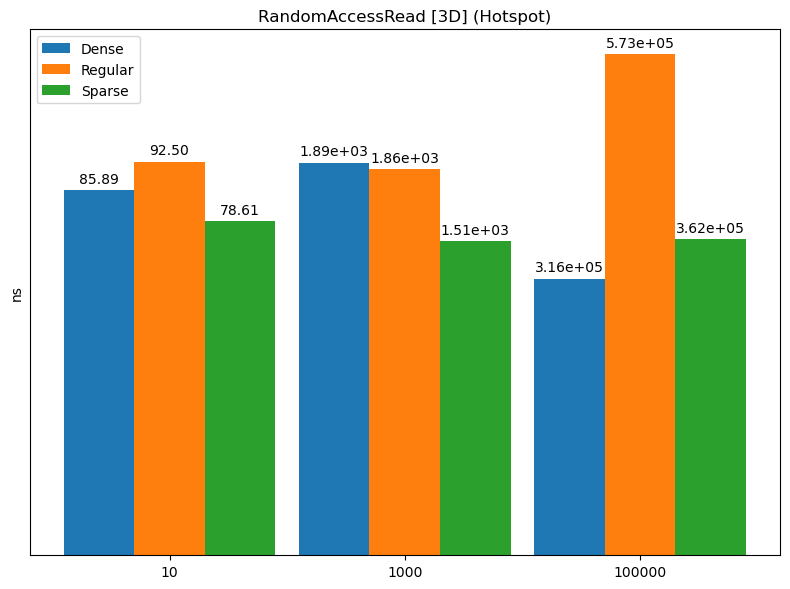

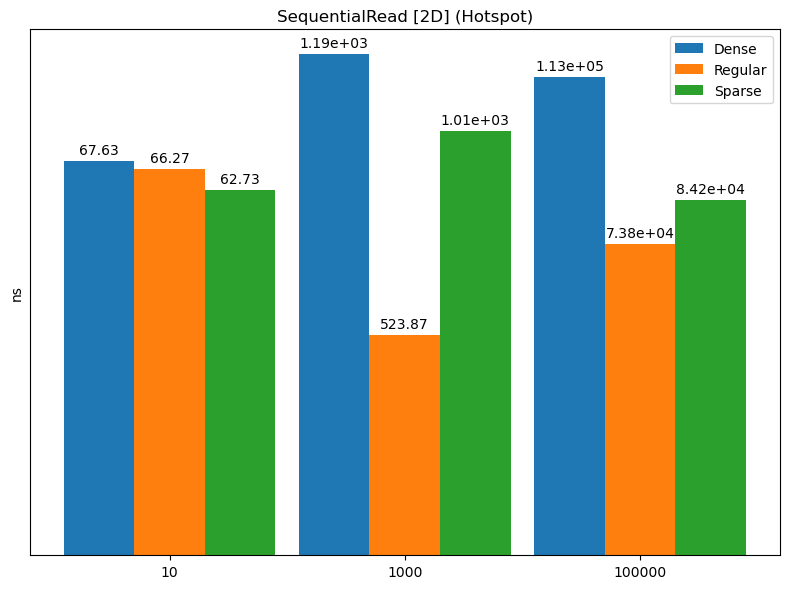

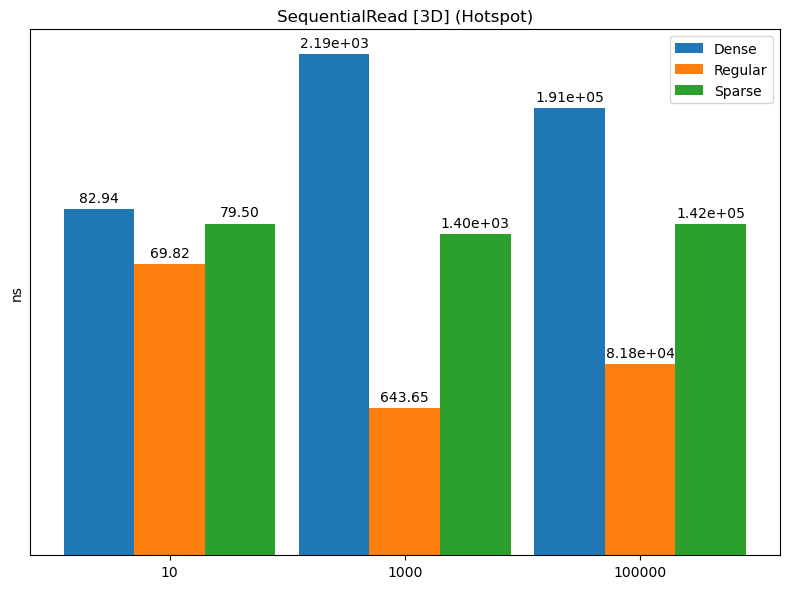

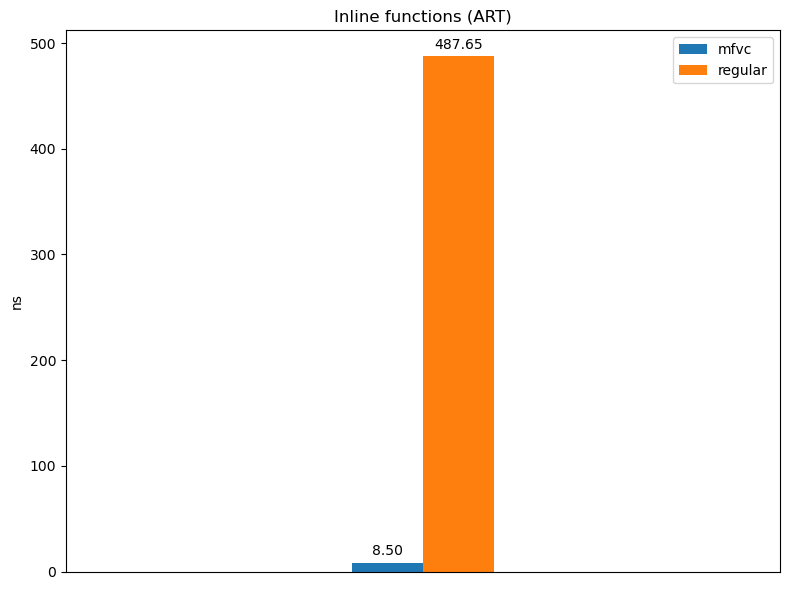

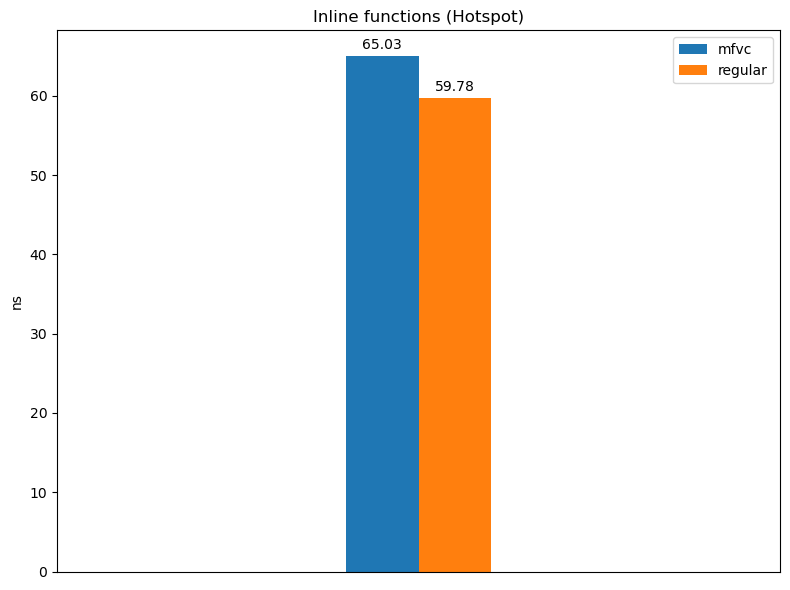

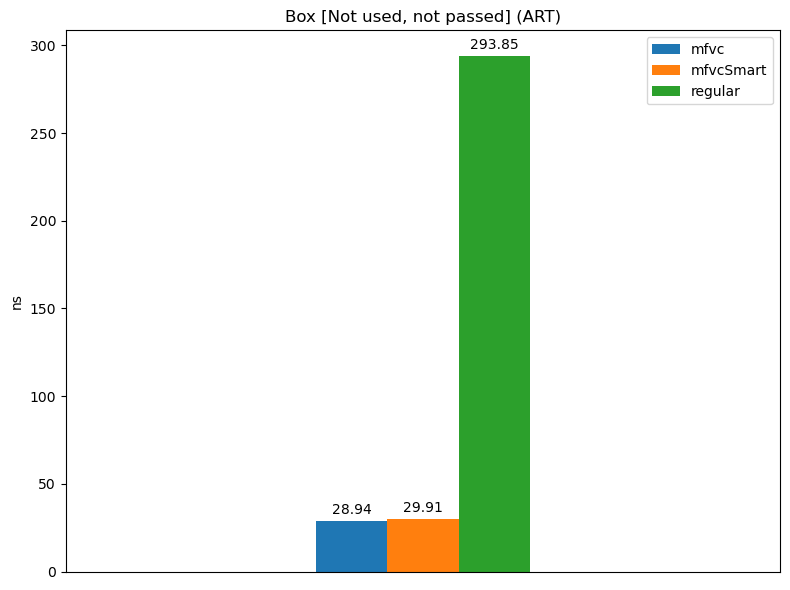

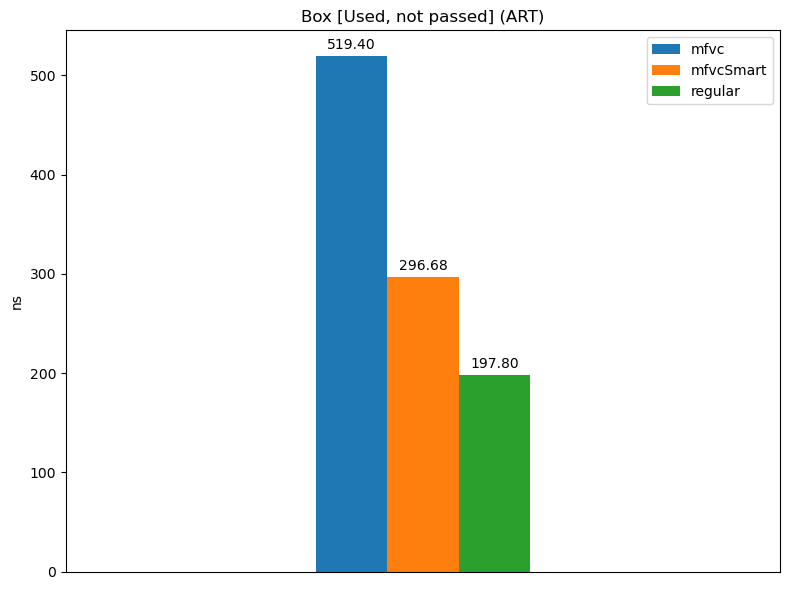

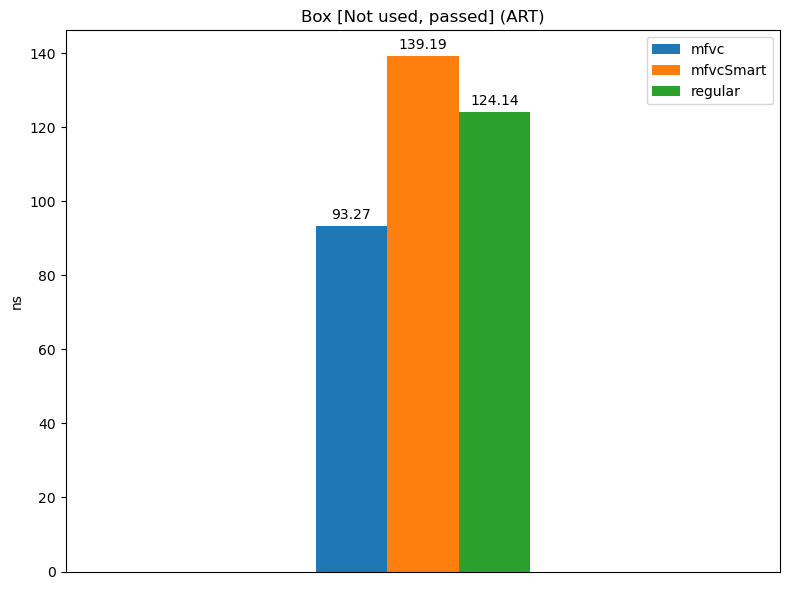

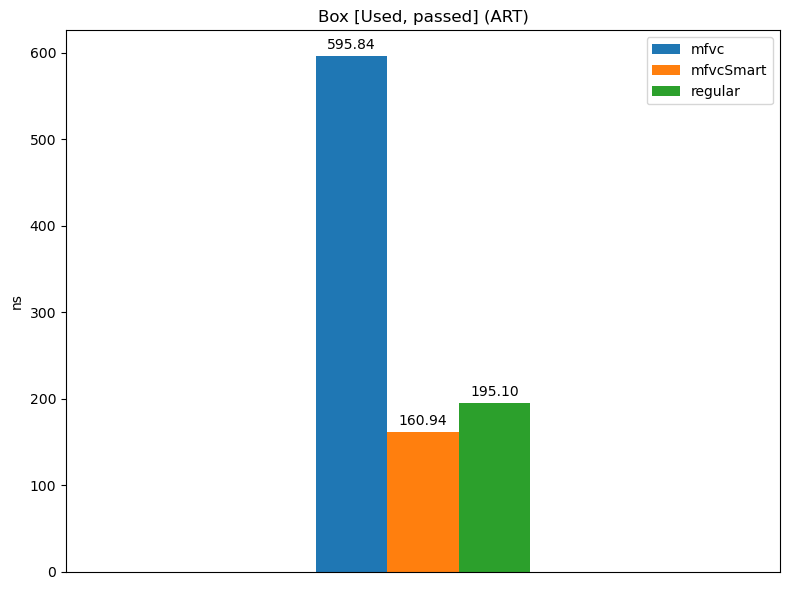

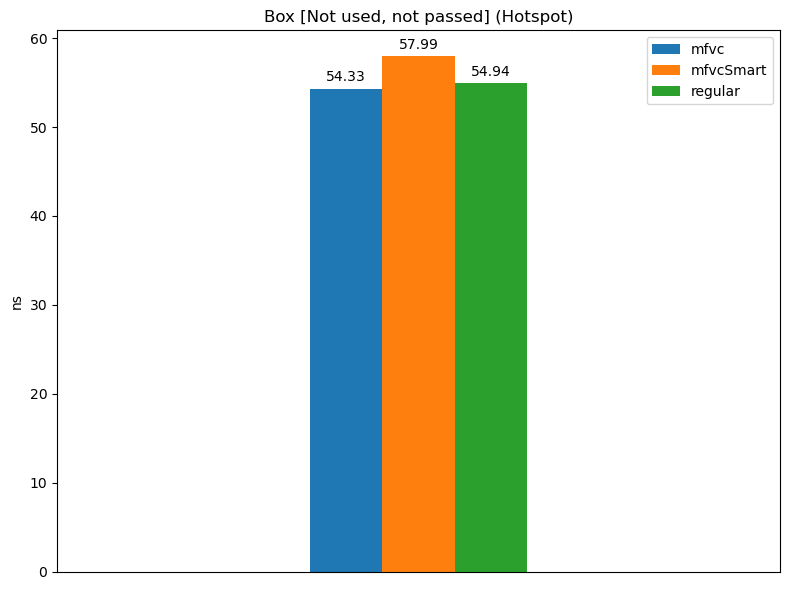

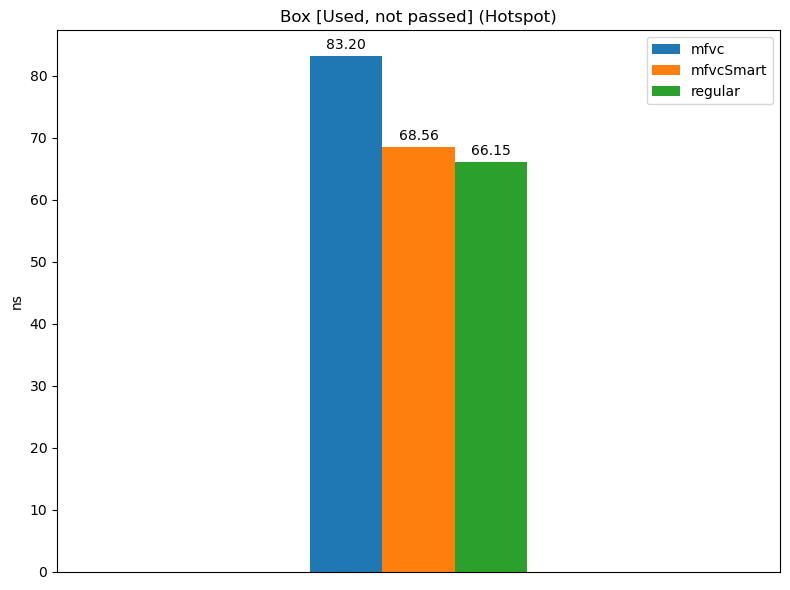

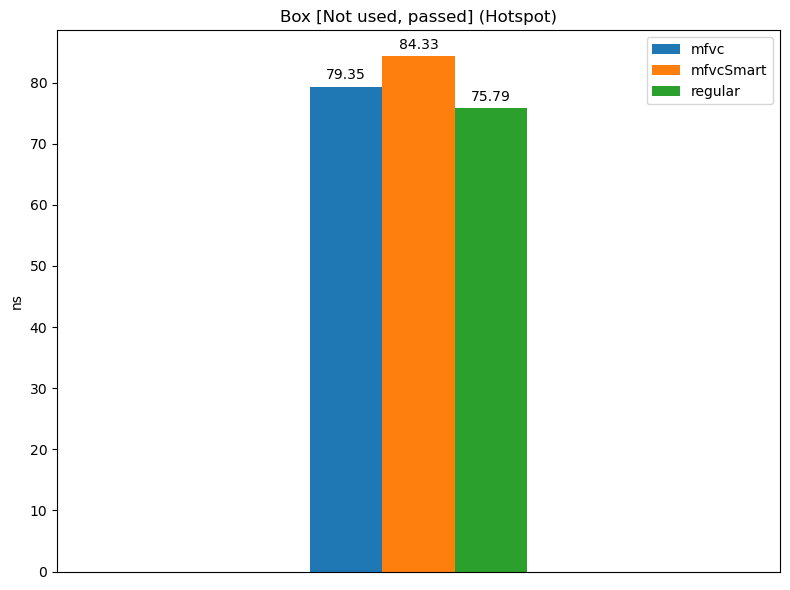

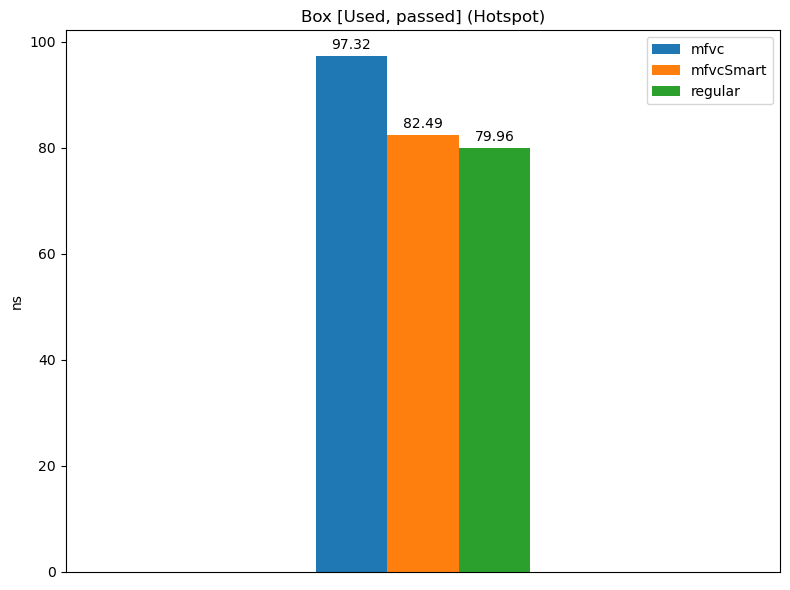

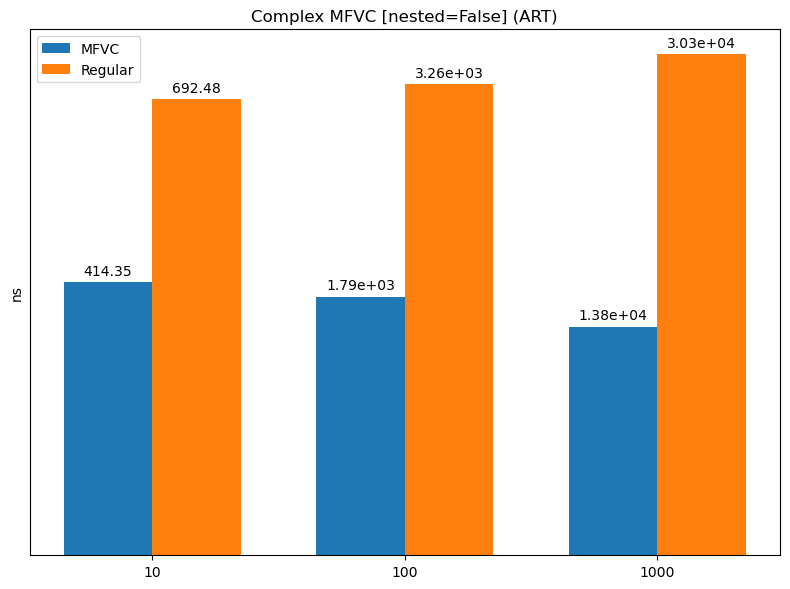

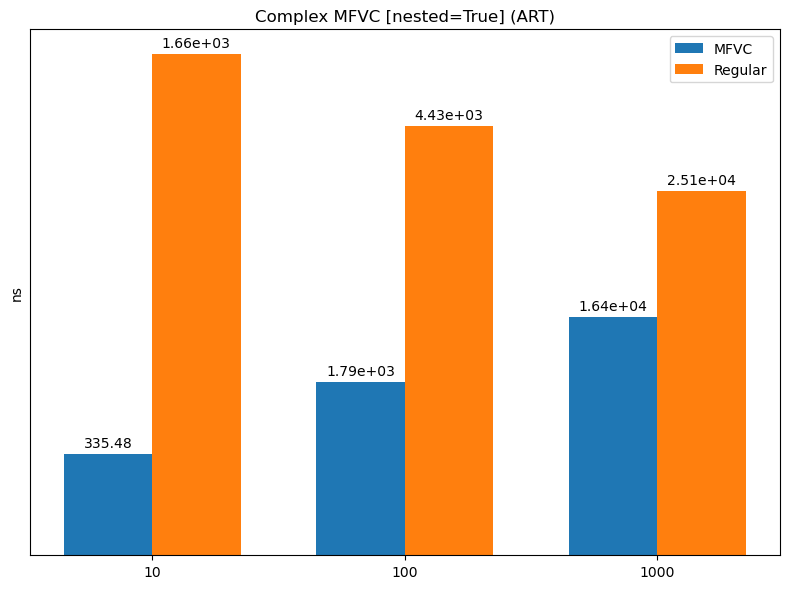

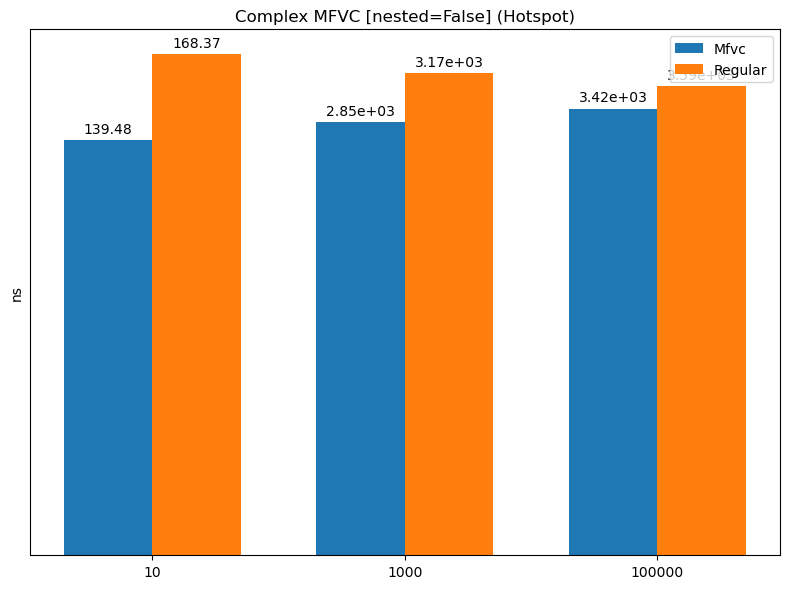

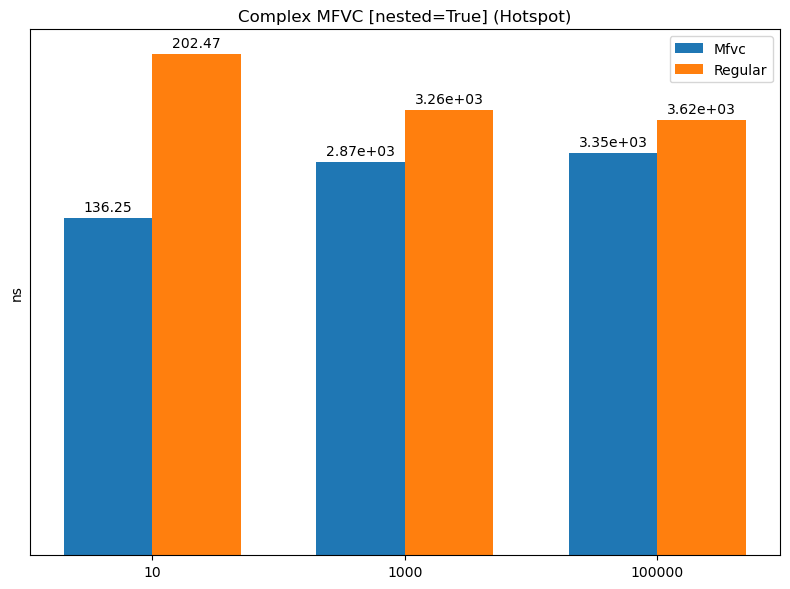

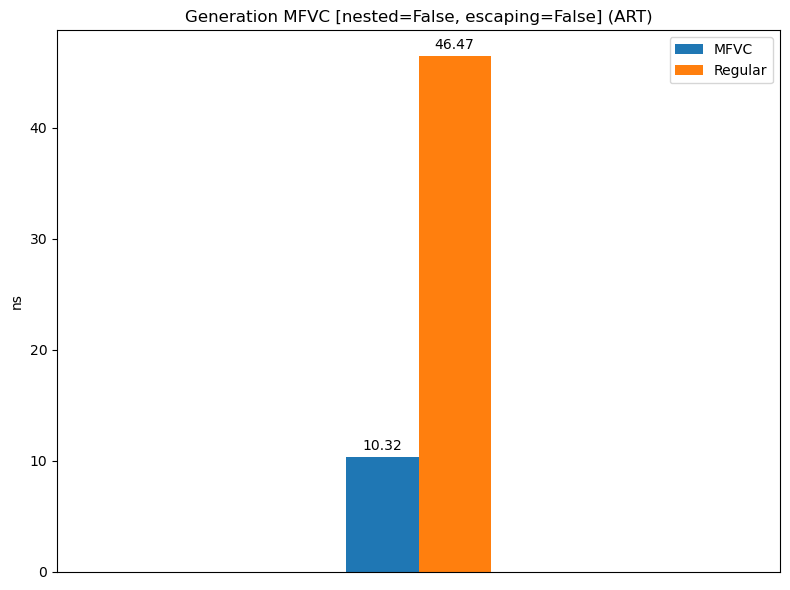

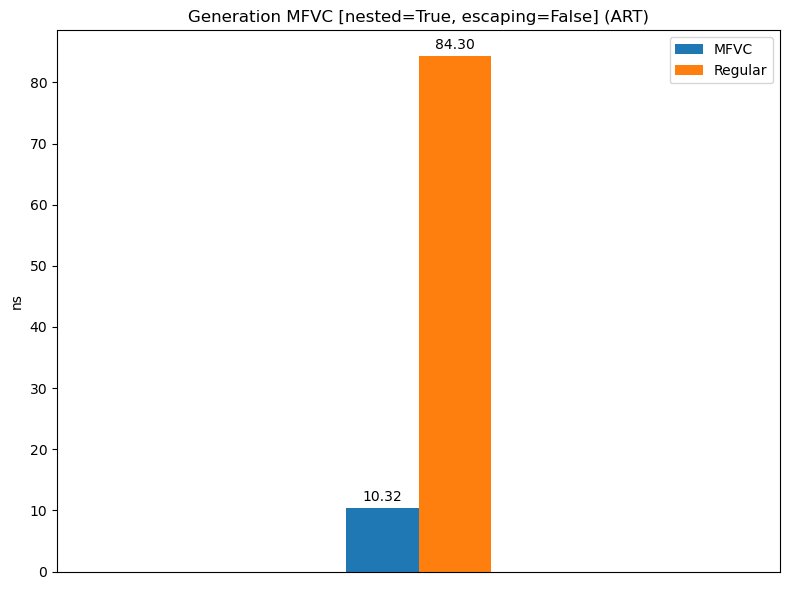

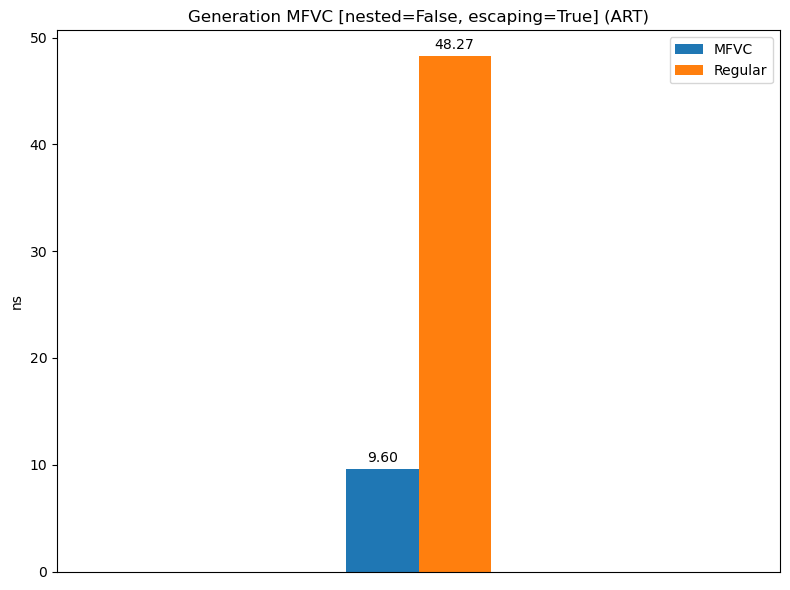

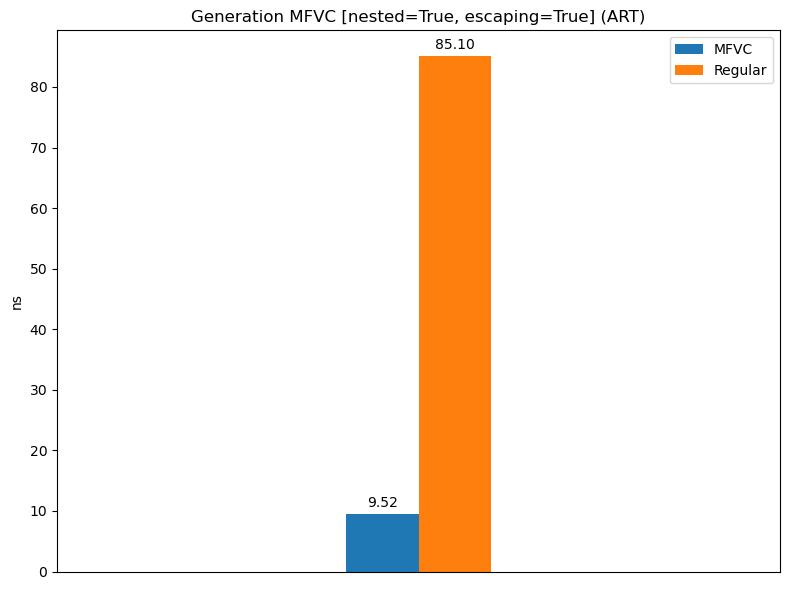

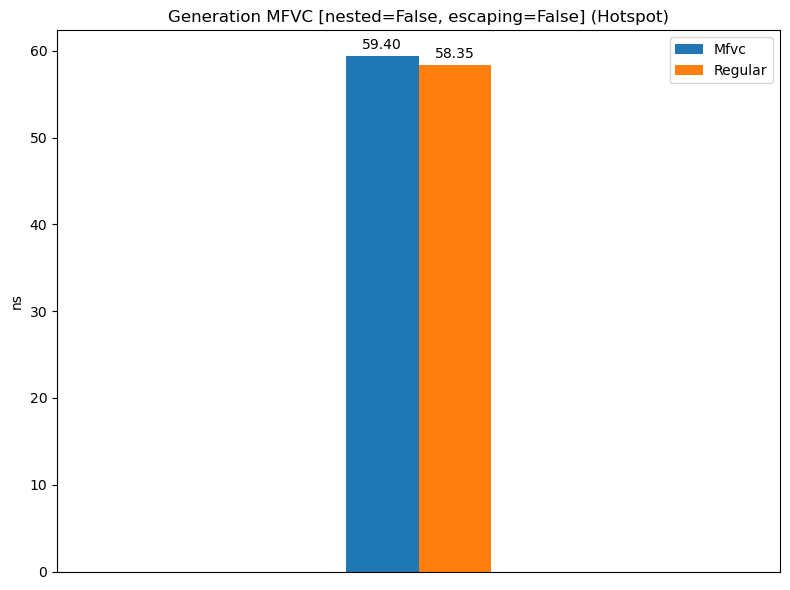

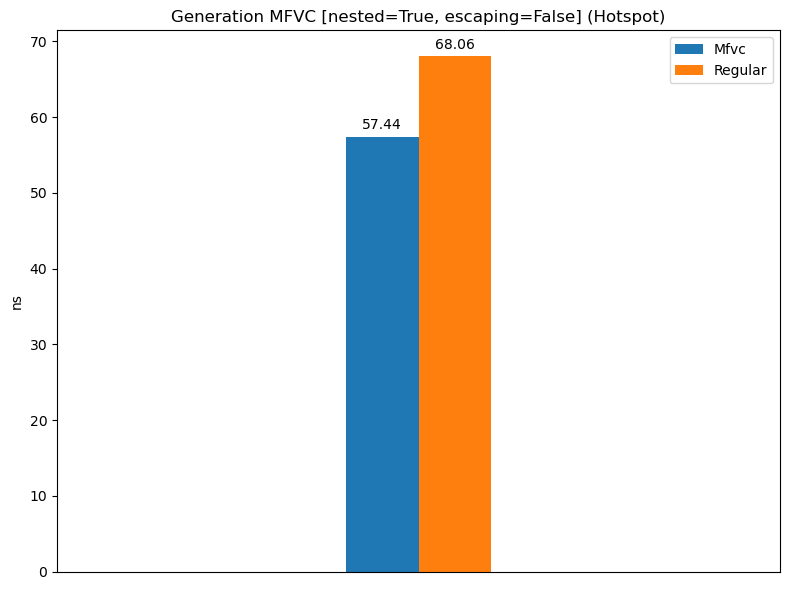

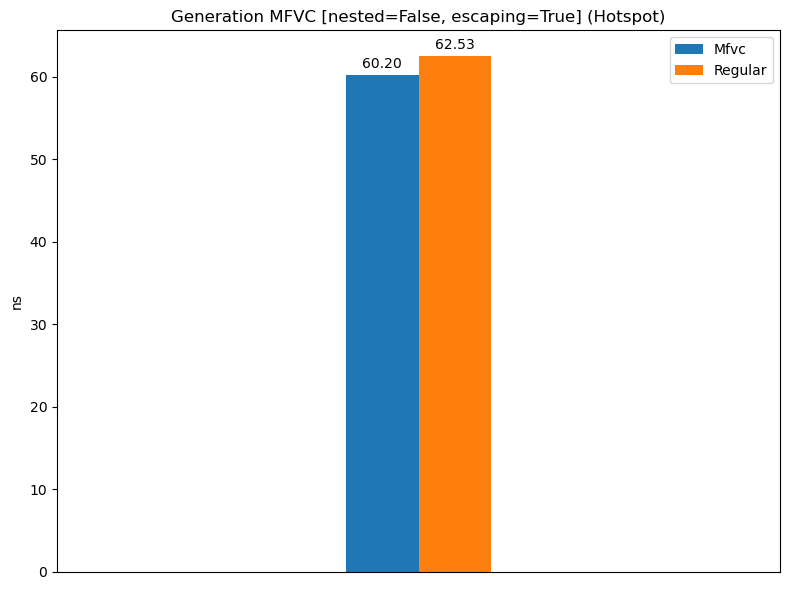

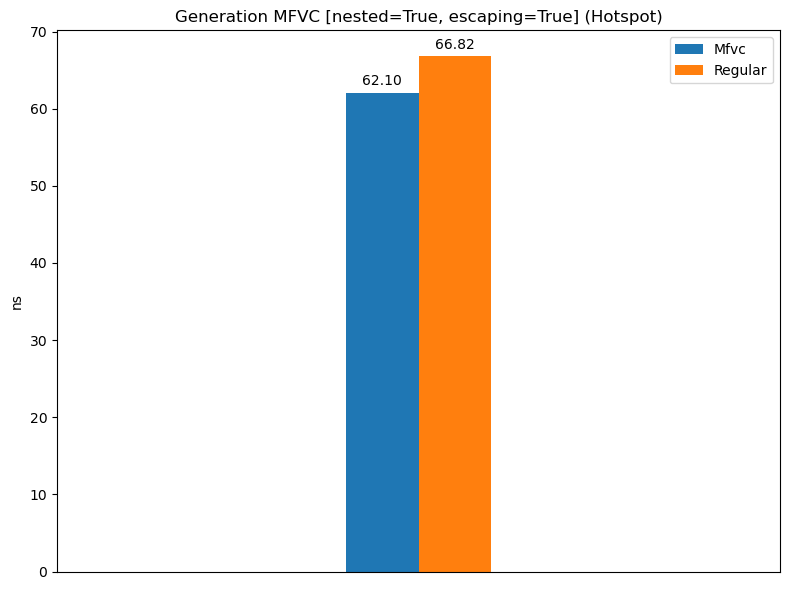

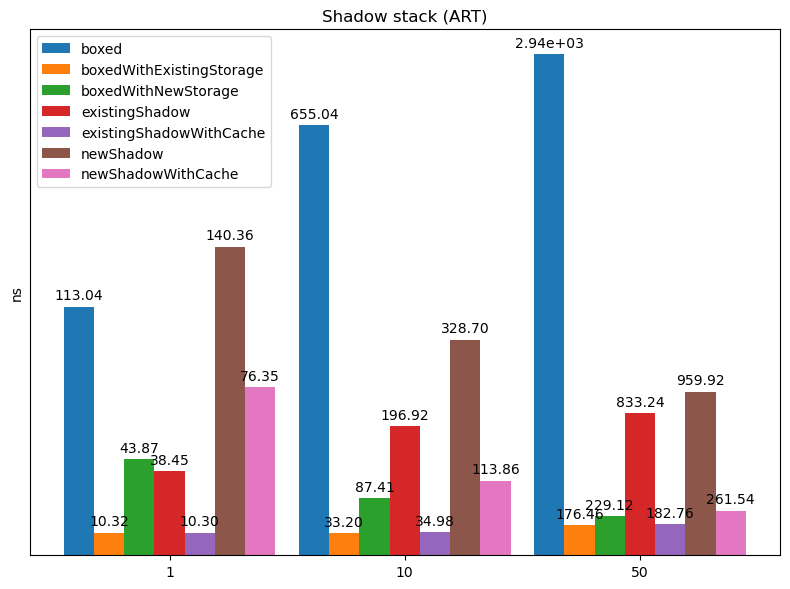

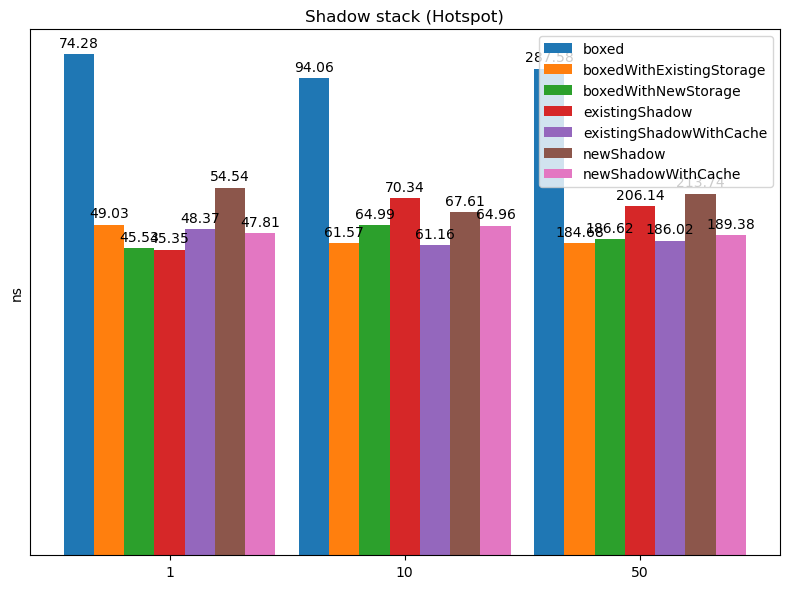

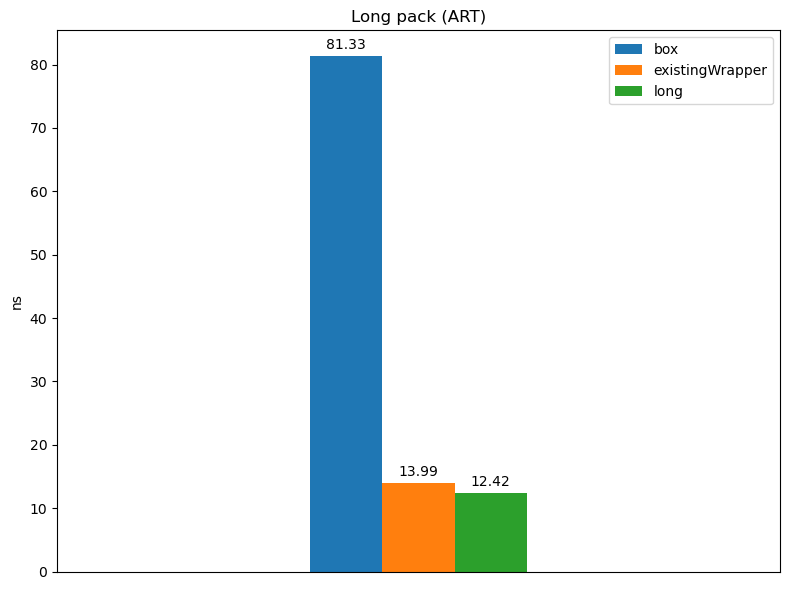

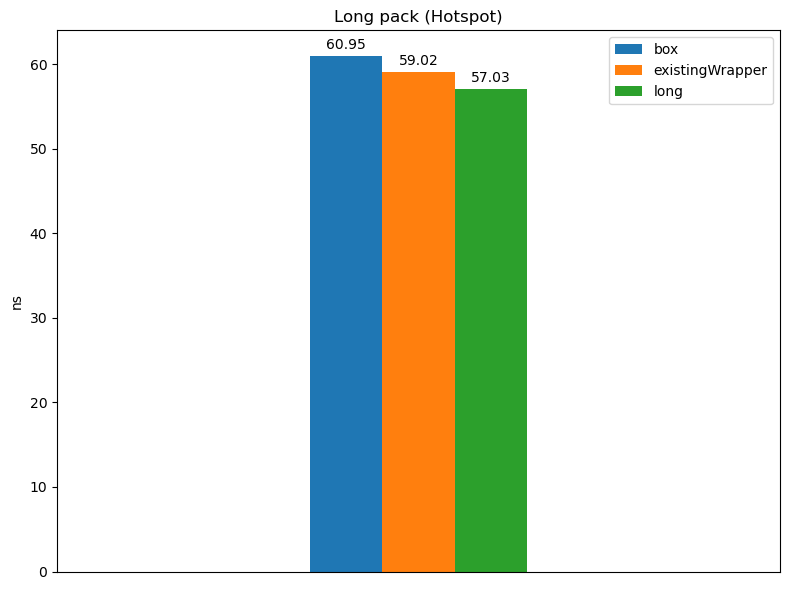

In [18]:
def clear_pics():
    import os
    for filename in os.listdir(pic_prefix):
        file_path = os.path.join(pic_prefix, filename)
        os.unlink(file_path)
def save_pics():
    make_histogram(save=True, show=False, maps=read_varrays_data(), title=lambda x: f'{make_title_string(x.name)} [{x.dimension}] ({x.platform})')
    make_histogram(save=True, show=False, maps=read_inline_functions_usage_data(), title=lambda x: f'Inline functions ({x.platform})')
    make_histogram(save=True, show=False, maps=read_box_usage_data(), title=lambda x: f'Box [{"Used" if x.behavior.is_box_used else "Not used"}, {"passed" if x.behavior.is_box_passed else "not passed"}] ({x.platform})')
    make_histogram(save=True, show=False, maps=read_complex_usage_data(), title=lambda x: f'Complex MFVC [nested={x.nested}] ({x.platform})')
    make_histogram(save=True, show=False, maps=read_generation_usage_data(), title=lambda x: f'Generation MFVC [nested={x.nested}, escaping={x.escaping}] ({x.platform})')
    make_histogram(save=True, show=False, maps=read_shadow_stack_data(), title=lambda x: f'Shadow stack ({x.platform})')
    make_histogram(save=True, show=False, maps=read_long_pack_data(), title=lambda x: f'Long pack ({x.platform})')

clear_pics()
save_pics()